In [2]:
# Создаём спарк контекст
from pyspark.sql import SparkSession
from pyspark.ml.functions import vector_to_array
import pyspark.sql.functions as F

from pyspark.ml.feature import HashingTF, IDF, Tokenizer, Word2Vec
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.classification import FMClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MultilabelClassificationEvaluator


import pandas as pd
import tqdm


spark = SparkSession.builder\
        .master('local[40]')\
        .appName('HW5')\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

sc = spark.sparkContext

22/12/11 00:37:29 WARN Utils: Your hostname, user-ubuntu-pc resolves to a loopback address: 127.0.1.1; using 192.168.1.7 instead (on interface wlo1)
22/12/11 00:37:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/11 00:37:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


tfidf

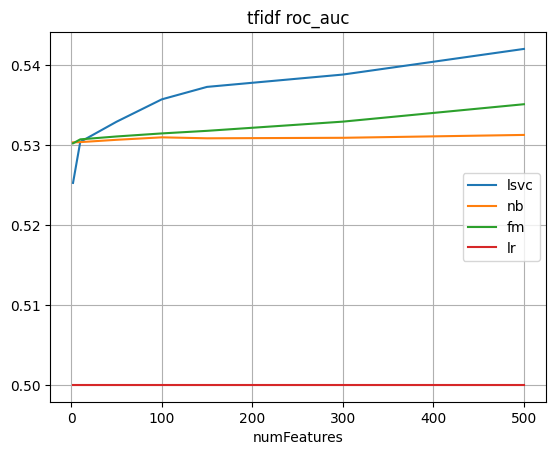

w2v

Загружаем данные:

In [3]:
train = spark.read.csv('jigsaw-toxic-comment-classification-challenge/train.csv', sep=',', quote='\"', escape='\"', multiLine=True, header=True, inferSchema=True)
test = spark.read.csv('jigsaw-toxic-comment-classification-challenge/test.csv', sep=',', quote='\"', escape='\"', multiLine=True, header=True, inferSchema=True)
test_labels = spark.read.csv('jigsaw-toxic-comment-classification-challenge/test_labels.csv', sep=',', quote='\"', escape='\"', multiLine=True, header=True, inferSchema=True)

In [4]:
target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate',]
num_features = [2, 10, 50, 75, 100, 150, 300, 500]

test = test.join(test_labels.select('id', *[(F.col(col) * -1).alias(col) for col in target_cols]), 'id')

Рассчитываем скоры tfidf:

In [5]:
tokenizer = Tokenizer(inputCol="comment_text", outputCol="words")

train_tokenized = tokenizer.transform(train).cache()
test_tokenized = tokenizer.transform(test).cache()

nums_scores = []
for numFeatures in tqdm.tqdm(num_features):
    

    hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="tf", numFeatures=numFeatures)
    idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")

    tf_idf_pipe = Pipeline(stages=[hashingTF, idf])
    tf_idf_pipe = tf_idf_pipe.fit(train_tokenized)
    train_tfidf = tf_idf_pipe.transform(train_tokenized)
    test_tfidf = tf_idf_pipe.transform(test_tokenized)

    for model in tqdm.tqdm(['lsvc', 'nb', 'fm', 'lr',]):
        model_stages = []
        for target_name in target_cols:
            if model == 'lr':
                model_stages.append(
                    LogisticRegression(featuresCol=idf.getOutputCol(), labelCol=target_name, probabilityCol=f'{target_name}__probabilityCol', rawPredictionCol=f'{target_name}__rawPredictionCol',  predictionCol=f'{target_name}__predictionCol', maxIter=10, regParam=0.3, elasticNetParam=0.8)
                )
            elif model == 'lsvc':
                model_stages.append(
                    LinearSVC(featuresCol=idf.getOutputCol(), labelCol=target_name, rawPredictionCol=f'{target_name}__rawPredictionCol',  predictionCol=f'{target_name}__predictionCol', maxIter=10, regParam=0.1)
                )
            elif model == 'nb':
                model_stages.append(
                    NaiveBayes(featuresCol=idf.getOutputCol(), labelCol=target_name, probabilityCol=f'{target_name}__probabilityCol', rawPredictionCol=f'{target_name}__rawPredictionCol',  predictionCol=f'{target_name}__predictionCol', smoothing=1.0, modelType="multinomial")
                )
            elif model == 'fm':
                model_stages.append(
                    FMClassifier(featuresCol=idf.getOutputCol(), labelCol=target_name, probabilityCol=f'{target_name}__probabilityCol', rawPredictionCol=f'{target_name}__rawPredictionCol',  predictionCol=f'{target_name}__predictionCol', stepSize=0.001)
                )

        model_pipe = Pipeline(stages=model_stages)
        models_transformer = model_pipe.fit(train_tfidf)
        results = models_transformer.transform(test_tfidf)\
            .select(*target_cols, *[f'{x}__rawPredictionCol' for x in target_cols]).cache()
        scores = []
        for target_name in target_cols:

            metrics = BinaryClassificationEvaluator(
                labelCol=target_name, 
                rawPredictionCol=f'{target_name}__rawPredictionCol'
            )
            scores.append(metrics.evaluate(results))
        results.unpersist()
        nums_scores.append((numFeatures, model, sum(scores) / len(target_cols)))

train_tokenized.unpersist()
test_tokenized.unpersist()

22/12/11 00:38:18 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 


22/12/11 00:38:45 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 


22/12/11 00:39:04 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 


                                                                                
                                                                                
                                                                                
                                                                                
100%|██████████| 4/4 [04:05<00:00, 61.37s/it]
                                                                                


22/12/11 00:43:15 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 


                                                                                
                                                                                
                                                                                
                                                                                
100%|██████████| 4/4 [06:04<00:00, 91.08s/it] 
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
100%|██████████| 4/4 [10:53<00:00, 163.47s/it]
                                                                                
                                                                                
               

22/12/11 01:07:26 WARN BlockManager: Asked to remove block broadcast_8656, which does not exist


                                                                                
                                                                                
100%|██████████| 4/4 [13:07<00:00, 196.81s/it]
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
100%|██████████| 4/4 [14:32<00:00, 218.00s/it]
                                                                                


22/12/11 01:27:32 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/12/11 01:27:32 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


                                                                                
                                                                                
                                                                                
                                                                                
100%|██████████| 4/4 [16:10<00:00, 242.56s/it]
                                                                                
                                                                                
                                                                                


22/12/11 01:48:21 WARN BlockManager: Asked to remove block broadcast_13891, which does not exist


22/12/11 01:58:27 WARN BlockManager: Asked to remove block broadcast_14837, which does not exist


                                                                                
                                                                                
100%|██████████| 7/7 [1:22:34<00:00, 707.78s/it]


DataFrame[id: string, comment_text: string, toxic: int, severe_toxic: int, obscene: int, threat: int, insult: int, identity_hate: int, words: array<string>]

Сторим график:

Text(0.5, 1.0, 'tfidf roc_auc')

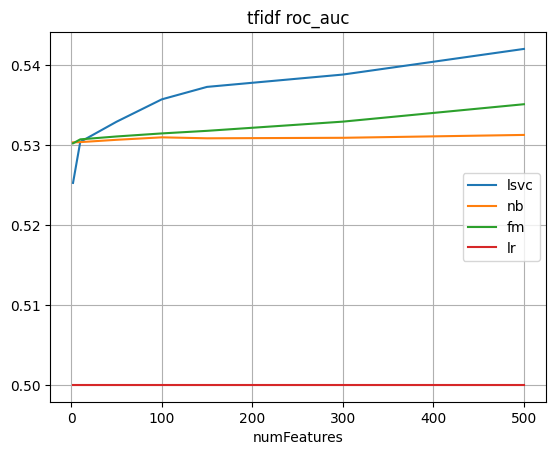

In [6]:
results = pd.DataFrame(nums_scores, columns=['numFeatures', 'linear_model', 'roc_auc'])

model = 'lsvc'
ax = results[results['linear_model'] == model]\
    .set_index('numFeatures')\
    .rename(columns={'roc_auc': model})\
    .plot(grid=True, label=model)

for model in ['nb', 'fm', 'lr',]: 
    results[results['linear_model'] == model]\
    .set_index('numFeatures')\
    .rename(columns={'roc_auc': model})\
    .plot(grid=True, label=model, ax=ax)
ax.set_title('tfidf roc_auc')

Рассчитываем скоры w2v:

In [ ]:
tokenizer = Tokenizer(inputCol="comment_text", outputCol="words")

train_tokenized = tokenizer.transform(train).cache()
test_tokenized = tokenizer.transform(test).cache()

nums_scores_2 = []
for numFeatures in tqdm.tqdm(num_features):

    hashingTF = Word2Vec(inputCol=tokenizer.getOutputCol(), outputCol="tf", vectorSize=numFeatures)

    tf_idf_pipe = Pipeline(stages=[hashingTF, idf])
    tf_idf_pipe = tf_idf_pipe.fit(train_tokenized)
    train_tfidf = tf_idf_pipe.transform(train_tokenized)
    test_tfidf = tf_idf_pipe.transform(test_tokenized)

    for model in tqdm.tqdm(['lsvc', 'fm', 'lr',]):
        model_stages = []
        for target_name in target_cols:
            if model == 'lr':
                model_stages.append(
                    LogisticRegression(featuresCol=idf.getOutputCol(), labelCol=target_name, probabilityCol=f'{target_name}__probabilityCol', rawPredictionCol=f'{target_name}__rawPredictionCol',  predictionCol=f'{target_name}__predictionCol', maxIter=10, regParam=0.3, elasticNetParam=0.8)
                )
            elif model == 'lsvc':
                model_stages.append(
                    LinearSVC(featuresCol=idf.getOutputCol(), labelCol=target_name, rawPredictionCol=f'{target_name}__rawPredictionCol',  predictionCol=f'{target_name}__predictionCol', maxIter=10, regParam=0.1)
                )
            elif model == 'fm':
                model_stages.append(
                    FMClassifier(featuresCol=idf.getOutputCol(), labelCol=target_name, probabilityCol=f'{target_name}__probabilityCol', rawPredictionCol=f'{target_name}__rawPredictionCol',  predictionCol=f'{target_name}__predictionCol', stepSize=0.001)
                )

        model_pipe = Pipeline(stages=model_stages)
        models_transformer = model_pipe.fit(train_tfidf)
        results = models_transformer.transform(test_tfidf).select(*target_cols, *[f'{x}__rawPredictionCol' for x in target_cols]).cache()
        
        scores = []
        for target_name in target_cols:

            metrics = BinaryClassificationEvaluator(labelCol=target_name, rawPredictionCol=f'{target_name}__rawPredictionCol')
            scores.append(metrics.evaluate(results))

        results.unpersist()
        nums_scores_2.append((numFeatures, model, sum(scores) / len(target_cols)))

train_tokenized.unpersist()
test_tokenized.unpersist()

22/12/11 02:21:14 WARN CacheManager: Asked to cache already cached data.
22/12/11 02:21:14 WARN CacheManager: Asked to cache already cached data.
